In [6]:
# For the attribute find functions.
import os

from stylex_train import StylEx, Dataset, DistributedSampler, MNIST_1vA

# For setting data src.
from  stylex_train import image_noise, styles_def_to_tensor, make_weights_for_balanced_classes, cycle, default

from mobilenet_classifier import MobileNet
import torch
from torch.utils import data
import math
import tqdm

import multiprocessing
from torchvision.utils import make_grid
from PIL import Image

import torch.nn.functional as F

# For reading lines and converting them to dict.
import ast

import h5py

NUM_CORES = multiprocessing.cpu_count()

def plot_image(tensor) -> None:
    """
    Plots an image from a tensor.
    """
    grid = make_grid(tensor,nrow=5)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)

    # Plot PIL image using plt.imshow
    display(im)


def set_data_src(folder='./', dataset_name=None, image_size=32, batch_size=16, num_workers=4,
                 is_ddp=False, rank=0, world_size=1):
    if dataset_name is None:
        dataset = Dataset(folder, image_size)
        num_workers = default(num_workers, NUM_CORES if not is_ddp else 0)

        sampler = DistributedSampler(dataset, rank=rank, num_replicas=world_size,
                                     shuffle=True) if is_ddp else None

        dataloader = data.DataLoader(dataset, num_workers=num_workers,
                                     batch_size=math.ceil(batch_size / world_size), sampler=sampler,
                                     shuffle=False, drop_last=True, pin_memory=True)

    elif dataset_name == 'MNIST':

        dataset = MNIST_1vA(digit=8)

        # weights = make_weights_for_balanced_classes(dataset.dataset, num_classes)
        # sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

        dataloader = data.DataLoader(dataset, batch_size=batch_size)
    else:
        raise NotImplementedError("This dataset is not supported yet. Please use dataset_name = None.")

    loader = cycle(dataloader)

    return dataset, loader


def sindex_to_block_idx_and_index(generator, sindex):
    tmp_idx = sindex

    block_idx = None
    idx = None

    for idx, block in enumerate(generator.blocks):
        if tmp_idx < block.num_style_coords:
            block_idx = idx
            idx = tmp_idx
            break
        else:
            tmp_idx = tmp_idx - block.num_style_coords

    return block_idx, idx


def _float_features(values):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=values))


def get_min_max_style_vectors(stylex, classifier, loader, batch_size, num_images=264, cuda_rank=0, image_size=32):
    minimums = None
    maximums = None

    minimums = None
    maximums = None

    for _ in range(num_images // batch_size):
        encoder_batch = next(loader).cuda(cuda_rank)

        encoder_output = stylex.encoder(encoder_batch)

        real_classified_logits = classifier.classify_images(encoder_batch)

        noise = image_noise(batch_size, image_size, device=cuda_rank)
        #zero_noise = torch.zeros(batch_size, image_size, image_size, 1).cuda(cuda_rank)

        latent_w = [(torch.cat((encoder_output, real_classified_logits), dim=1),
                     stylex.G.num_layers)]  # Has to be bracketed because expects a noise mix

        # dlatents.append(encoder_output)
        w_latent_tensor = styles_def_to_tensor(latent_w)

        rgb, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)

        if minimums is None or maximums is None:
            minimums = style_coords
            maximums = style_coords
        else:
            minimums = torch.minimum(minimums, style_coords)
            maximums = torch.maximum(maximums, style_coords)

    minimums = torch.min(minimums, dim=0)[0]
    maximums = torch.max(maximums, dim=0)[0]

    return minimums, maximums


def filter_unstable_images(style_change_effect: torch.Tensor,
                           effect_threshold: float = 0.3,
                           num_indices_threshold: int = 150) -> torch.Tensor:
    """Filters out images which are affected by too many S values."""
    unstable_images = (
                torch.sum(torch.abs(style_change_effect) > effect_threshold, dim=(1, 2, 3)) > num_indices_threshold)
    style_change_effect[unstable_images] = 0
    return style_change_effect


def run_attrfind(
        data='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/plant-village/all/',
        stylex_path='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/stylex/models/plants_64_alt/model_160.pt',
        classifier_name='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/stylex/trained_classifiers/plant-village-64_2.pt',
        image_size=64,
        num_images=4,
        batch_size=16,
        dataset_name=None,
        s_shift_size=0.5,
        att_find_text_file="./att_find/att_find_computations.txt"
):
    with torch.no_grad():
        dataset, loader = set_data_src(data, dataset_name, image_size, batch_size)
        # Since attribute find is not helped by having multiple GPU's, we hardcode cuda_rank to 0.
        cuda_rank = 0

        stylex = StylEx(image_size=image_size)

        # smt like this

        stylex.load_state_dict(torch.load(stylex_path)["StylEx"])

        classifier = MobileNet(classifier_name, cuda_rank=cuda_rank, output_size=2, image_size=image_size)

        minimums, maximums = get_min_max_style_vectors(stylex, classifier, loader, batch_size=batch_size,
                                                       cuda_rank=cuda_rank, image_size=image_size)

        # Dictionary of features
        style_vector_amount = len(minimums)

        # Check if the att_find_text_file path exists, otherwise create a directory with the text file in there
        if not os.path.exists(os.path.dirname(att_find_text_file)):
            os.makedirs(os.path.dirname(att_find_text_file))

        noise = image_noise(batch_size, image_size, device=cuda_rank)[0].unsqueeze(0)

        #zero_noise = torch.zeros(1, image_size, image_size, 1).cuda(cuda_rank)

        # Check if the att_find_text_file exists, otherwise do the attfind computations.


        batch = next(loader).cuda(cuda_rank)
        batch = next(loader).cuda(cuda_rank)

        for i in range(10,20):

            img = batch[i].unsqueeze(0)
            img_logits = classifier.classify_images(img)
            img_probabilities =  F.softmax(img_logits, dim=1)

            plot_image(img)

            w = stylex.encoder(img).unsqueeze(0)

            latent_w = [(torch.cat((w, img_probabilities), dim=1), stylex.G.num_layers)]  
            w_latent_tensor = styles_def_to_tensor(latent_w)

            img_generated, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)

            img_generated_logits = classifier.classify_images(img_generated)
            img_generated_probabilities = F.softmax(classifier.classify_images(img_generated), dim=1)

            plot_image(img_generated)

            print(f'Logits of original image: {img_logits}')
            print(f'Logits of generated image: {img_generated_logits}')

            style_change_effect = torch.Tensor(1, style_coords.shape[1], 2, 2)

            largest_diff = -1e10
            largest_diff_idx = None
            largest_diff_direction = None

            for sindex in range(style_coords.shape[1]):
                block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                block = stylex.G.blocks[block_idx]

                # block.style1.bias [block.input_channels]
                # block.style2.bias [block.filters]

                current_style_layer = None
                one_hot = None

                if weight_idx < block.input_channels:
                    # While we're in style 1.
                    current_style_layer = block.to_style1
                    one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                else:
                    weight_idx -= block.input_channels
                    current_style_layer = block.to_style2
                    one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                one_hot[:, weight_idx] = 1

                s_shift_down = one_hot * (
                            (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                s_shift_up = one_hot * ((maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(
                    1)

                for direction_index, shift in enumerate([s_shift_down, s_shift_up]):
                    # for image_index, individual_shift in enumerate(shift):

                    image_index = 0

                    shift = shift.squeeze(0)

                    current_style_layer.bias += shift
                    perturbed_generated_images, style_coords = stylex.G(
                        w_latent_tensor,
                        noise,
                        get_style_coords=True)
                    shift_classification = classifier.classify_images(perturbed_generated_images)
                    style_change_effect[image_index, sindex, direction_index] = shift_classification - img_generated_logits

                    if largest_diff < style_change_effect[image_index, sindex, direction_index,  1]:
                        largest_diff = style_change_effect[image_index, sindex, direction_index, 1]
                        largest_diff_idx = (image_index, sindex, direction_index)
                        largest_diff_direction = direction_index

                    
                    if sindex == 32 and direction_index == 0:
                        plot_image(perturbed_generated_images)                
                    current_style_layer.bias -= shift

            print(f'Largest diff: {largest_diff}')
            print(f'Largest diff idx: {largest_diff_idx}')
            print(f'Largest diff direction: {largest_diff_direction}')


            for _cls in [0, 1]:

                changes_not8 = style_change_effect[0, :, :, _cls] # change 1 to 0 depending on which class we want to inspect
                changes_not8_flat = changes_not8.view(-1)
                changes_not8_sorted, changes_not8_indices = torch.sort(changes_not8_flat, descending=True)

                k_max = 20
                one_hot = None


                # Change the biases in the direction specified.
                
                images = []
                
                for k in range(1, k_max + 1):

                    top_k_changes, top_k_sindex, top_k_directions = changes_not8_sorted[:k], changes_not8_indices[:k] / 2, changes_not8_indices[:k] % 2

                    

                    for i in range(k):

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        


                        current_style_layer.bias += individual_shift[0]

            
                    # Generate the perturbed image
                    perturbed_img_generated = stylex.G(w_latent_tensor,
                                                                                        noise
                                                                        )            

                    images.append(perturbed_img_generated)

                    # Get the logits of the perturbed image

                    perturbed_img_generated_logits = F.softmax(classifier.classify_images(perturbed_img_generated), dim=1)

                    print(f'Logits of image with top-{k} attributes flipped: {perturbed_img_generated_logits}')


                    for i in range(k):

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)
                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)


                        current_style_layer.bias -= individual_shift[0]


                # stack list of tensor images into a single tensor

                images = torch.cat(images, dim=0)


                plot_image(images)

                import random

                images = []

                k = 10
                top_k_changes, top_k_sindex, top_k_directions = changes_not8_sorted[:k], changes_not8_indices[:k] / 2, changes_not8_indices[:k] % 2
                
                for j in range(10):

                    indices = random.choices(range(10), k=3)

                    for i in indices:
                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        




                        current_style_layer.bias += individual_shift[0]


                    # Generate the perturbed image
                    perturbed_img_generated = stylex.G(w_latent_tensor,
                                                                            noise,
                                                                    )            

                    images.append(perturbed_img_generated)

                    # Get the logits of the perturbed image

                    perturbed_img_generated_logits = F.softmax(classifier.classify_images(perturbed_img_generated), dim=1)

                    print(f'Logits of image with top-{indices} attributes flipped: {perturbed_img_generated_logits}')

                    for i in indices:

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)





                        current_style_layer.bias -= individual_shift[0]


                images = torch.cat(images, dim=0)

                print(images.shape)

                plot_image(images)

Using cache found in /home/tannin/.cache/torch/hub/pytorch_vision_v0.10.0


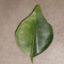

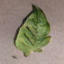

Logits of original image: tensor([[-5.1231,  4.6625]], device='cuda:0')
Logits of generated image: tensor([[-8.3539,  7.3534]], device='cuda:0')


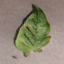

Largest diff: 5.661068439483643
Largest diff idx: (0, 2449, 1)
Largest diff direction: 1
Logits of image with top-1 attributes flipped: tensor([[3.5153e-05, 9.9996e-01]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[1.3137e-04, 9.9987e-01]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[1.3399e-04, 9.9987e-01]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[1.1006e-05, 9.9999e-01]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[1.8256e-04, 9.9982e-01]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[2.1106e-04, 9.9979e-01]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[0.0062, 0.9938]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[6.1088e-05, 9.9994e-01]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[6.0127e-05, 9.9994e-01]], device='cuda:0')
Logits of image with top-10 

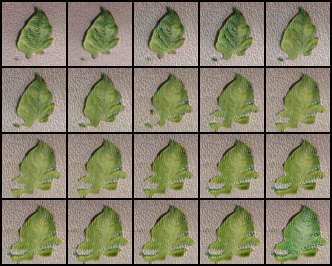

Logits of image with top-[7, 7, 4] attributes flipped: tensor([[5.1351e-05, 9.9995e-01]], device='cuda:0')
Logits of image with top-[1, 9, 7] attributes flipped: tensor([[3.1262e-08, 1.0000e+00]], device='cuda:0')
Logits of image with top-[6, 5, 9] attributes flipped: tensor([[0.0012, 0.9988]], device='cuda:0')
Logits of image with top-[7, 8, 7] attributes flipped: tensor([[7.9271e-06, 9.9999e-01]], device='cuda:0')
Logits of image with top-[1, 6, 6] attributes flipped: tensor([[1.3419e-07, 1.0000e+00]], device='cuda:0')
Logits of image with top-[3, 3, 0] attributes flipped: tensor([[7.3185e-06, 9.9999e-01]], device='cuda:0')
Logits of image with top-[0, 1, 9] attributes flipped: tensor([[5.4806e-05, 9.9995e-01]], device='cuda:0')
Logits of image with top-[1, 7, 5] attributes flipped: tensor([[3.5418e-08, 1.0000e+00]], device='cuda:0')
Logits of image with top-[5, 4, 4] attributes flipped: tensor([[8.1868e-05, 9.9992e-01]], device='cuda:0')
Logits of image with top-[6, 0, 9] attributes

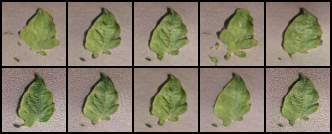

Logits of image with top-1 attributes flipped: tensor([[2.4968e-12, 1.0000e+00]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[8.3629e-13, 1.0000e+00]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[2.4004e-13, 1.0000e+00]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[9.7940e-14, 1.0000e+00]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[1.5603e-15, 1.0000e+00]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[4.1396e-16, 1.0000e+00]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[1.8064e-15, 1.0000e+00]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[3.6738e-14, 1.0000e+00]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[5.8129e-14, 1.0000e+00]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[1.0406e-13, 1.0000e+00]], device='cuda:0')
Logits of

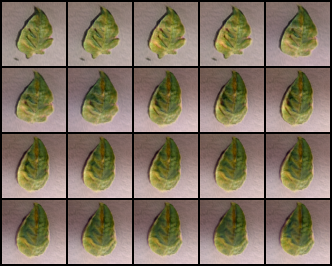

Logits of image with top-[0, 0, 2] attributes flipped: tensor([[1.4902e-12, 1.0000e+00]], device='cuda:0')
Logits of image with top-[2, 9, 3] attributes flipped: tensor([[3.3713e-11, 1.0000e+00]], device='cuda:0')
Logits of image with top-[6, 1, 4] attributes flipped: tensor([[2.1507e-15, 1.0000e+00]], device='cuda:0')
Logits of image with top-[0, 5, 2] attributes flipped: tensor([[9.0811e-15, 1.0000e+00]], device='cuda:0')
Logits of image with top-[4, 7, 1] attributes flipped: tensor([[1.5309e-13, 1.0000e+00]], device='cuda:0')
Logits of image with top-[1, 1, 2] attributes flipped: tensor([[2.7718e-14, 1.0000e+00]], device='cuda:0')
Logits of image with top-[8, 1, 2] attributes flipped: tensor([[1.5207e-12, 1.0000e+00]], device='cuda:0')
Logits of image with top-[6, 8, 6] attributes flipped: tensor([[7.5379e-13, 1.0000e+00]], device='cuda:0')
Logits of image with top-[6, 4, 9] attributes flipped: tensor([[3.0999e-12, 1.0000e+00]], device='cuda:0')
Logits of image with top-[5, 6, 2] at

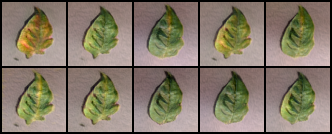

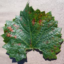

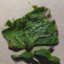

Logits of original image: tensor([[-9.2022,  8.5296]], device='cuda:0')
Logits of generated image: tensor([[-4.6113,  3.7769]], device='cuda:0')


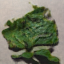

KeyboardInterrupt: 

In [7]:
run_attrfind()
